(log-reg-notebook)=
# Modello di regressione logistica

In questo tutorial utilizzeremo i dati forniti dal sito di `bambi` per illustrare il modello di regressione logistica. Questi dati provengono dallo studio pilota del 2016. Lo studio completo includeva 1200 persone, ma è stato selezionato un sottoinsieme di 487 persone che hanno risposto a una domanda riguardante se avrebbero votato per Hillary Clinton o Donald Trump.

In [2]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [4]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


La nostra variabile di esito è `vote`, che indica le risposte delle persone alla seguente domanda:

"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"

In [5]:
data["vote"].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

Per rendere l'analisi più semplice, considereremo solo le risposte delle persone che hanno indicato di voler votare per Clinton o Trump. Modelleremo quindi la probabilità di voto per Clinton.

In [7]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Per l'analisi di questi dati, potremmo essere tentati di utilizzare il modello lineare tradizionale; tuttavia, ciò non è possibile in questo caso a causa delle specifiche caratteristiche dei dati. In primo luogo, la variabile $Y$ è di tipo Bernoulliano, ovvero può assumere solo due valori possibili: 0 e 1, corrispondenti a due esiti distinti ("voto per Clinton" o "voto per Trump"). Questa natura discreta e categorica della variabile $Y$ rende incompatibile il modello di regressione tradizionale, che invece è concepito per variabili dipendenti continue.

Inoltre, il modello lineare tradizionale presuppone che l'aspettativa di $Y$ ($E(Y \mid X)$) sia un valore compreso nell'intervallo da meno infinito a più infinito, mentre $Y$ può assumere solo i valori 0 e 1. Questo aspetto incompatibile limita ulteriormente l'adeguatezza del modello lineare tradizionale per descrivere i dati in questione.

Per superare queste problematiche, possiamo adottare un approccio diverso: prevedere non il valore atteso di $Y$ direttamente, bensì il valore atteso di una sua trasformazione. Questa trasformazione di $Y$ viene chiamata "funzione link". Nella regressione logistica, la funzione link utilizzata è il logit, ovvero il logaritmo dell'odds ratio, rappresentato come:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)},
$$

dove $\pi$ rappresenta la probabilità di $Y$ essere 1. Il logit può assumere valori nell'intervallo da meno infinito a più infinito, rendendo così appropriato il modello di regressione logistica per dati con variabili di tipo Bernoulliano.

Pertanto, il modello di regressione logistica è essenzialmente un modello di regressione lineare che si focalizza sulla previsione di una trasformazione della variabile Bernoulliana $Y$, utilizzando il logaritmo dell'odds ratio come funzione link.

In modo equivalente, la probabilità di $Y$, indicata come $\pi$, può essere espressa come funzione del predittore lineare $\eta = \beta_0 + \beta_1 X$:

$$
\pi = \frac{e^\eta}{1 + e^\eta}= \frac{1}{1 + e^{-\eta}}.
$$

In questo modo, otteniamo un modello non lineare.

Nel nostro esempio, utilizzeremo un modello di regressione logistica per stimare la probabilità di votare per Clinton in funzione dell'età. Il nostro obiettivo è quindi modellare $\pi = P(Y = 1)$, ovvero la probabilità di votare per Clinton, utilizzando solo l'età come variabile esplicativa.

La regressione logistica collega il logit di $\pi$ a un predittore o a una combinazione lineare di predittori. Nella nostra situazione, l'equazione matematica del modello sarà la seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X,
$$

dove $X$ rappresenta l'età.

Inoltre, per utilizzare l'approccio bayesiano, dobbiamo specificare una distribuzione a priori per i parametri e una funzione di verosimiglianza. Nella nostra analisi, utilizzeremo le distribuzioni a priori predefinite di Bambi e la verosimiglianza sarà il prodotto delle prove Bernoulliane, ovvero il prodotto delle probabilità $\prod_{i=1}^{n}{p_i^{y_i}(1-p_i)^{1-y_i}}$, dove $p_i = P(Y=1)$ e $y_i = 1$ se l'intenzione di voto è per Clinton e $y_i = 0$ se per Trump.

### Specificare e adattare il modello in Bambi

La specificazione e l'adattamento del modello sono semplici. Per utilizzare Bambi, è sufficiente specificare il modello utilizzando la sintassi delle formule e passare l'argomento `family` corretto. È importante notare la sintassi opzionale utilizzata sul lato sinistro della formula: `vote[clinton]` indica a Bambi di modellare la probabilità che `vote=='clinton'`, invece della probabilità che `vote=='trump'`.

Sul lato destro della formula, utilizziamo `age` per indicare a Bambi che vogliamo utilizzare `age` come unica variabile esplicativa nel modello.

In [9]:
clinton_model = bmb.Model(
    "vote['clinton'] ~ age", clinton_data, family="bernoulli"
)

In [10]:
clinton_fitted = clinton_model.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    idata_kwargs={"log_likelihood": True},
)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


Possiamo stampare l'oggetto `clinton_model` per visualizzare informazioni sulla distribuzione della risposta, la funzione link e le distribuzioni a priori.

In [11]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, age]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'age'}>], dtype=object)

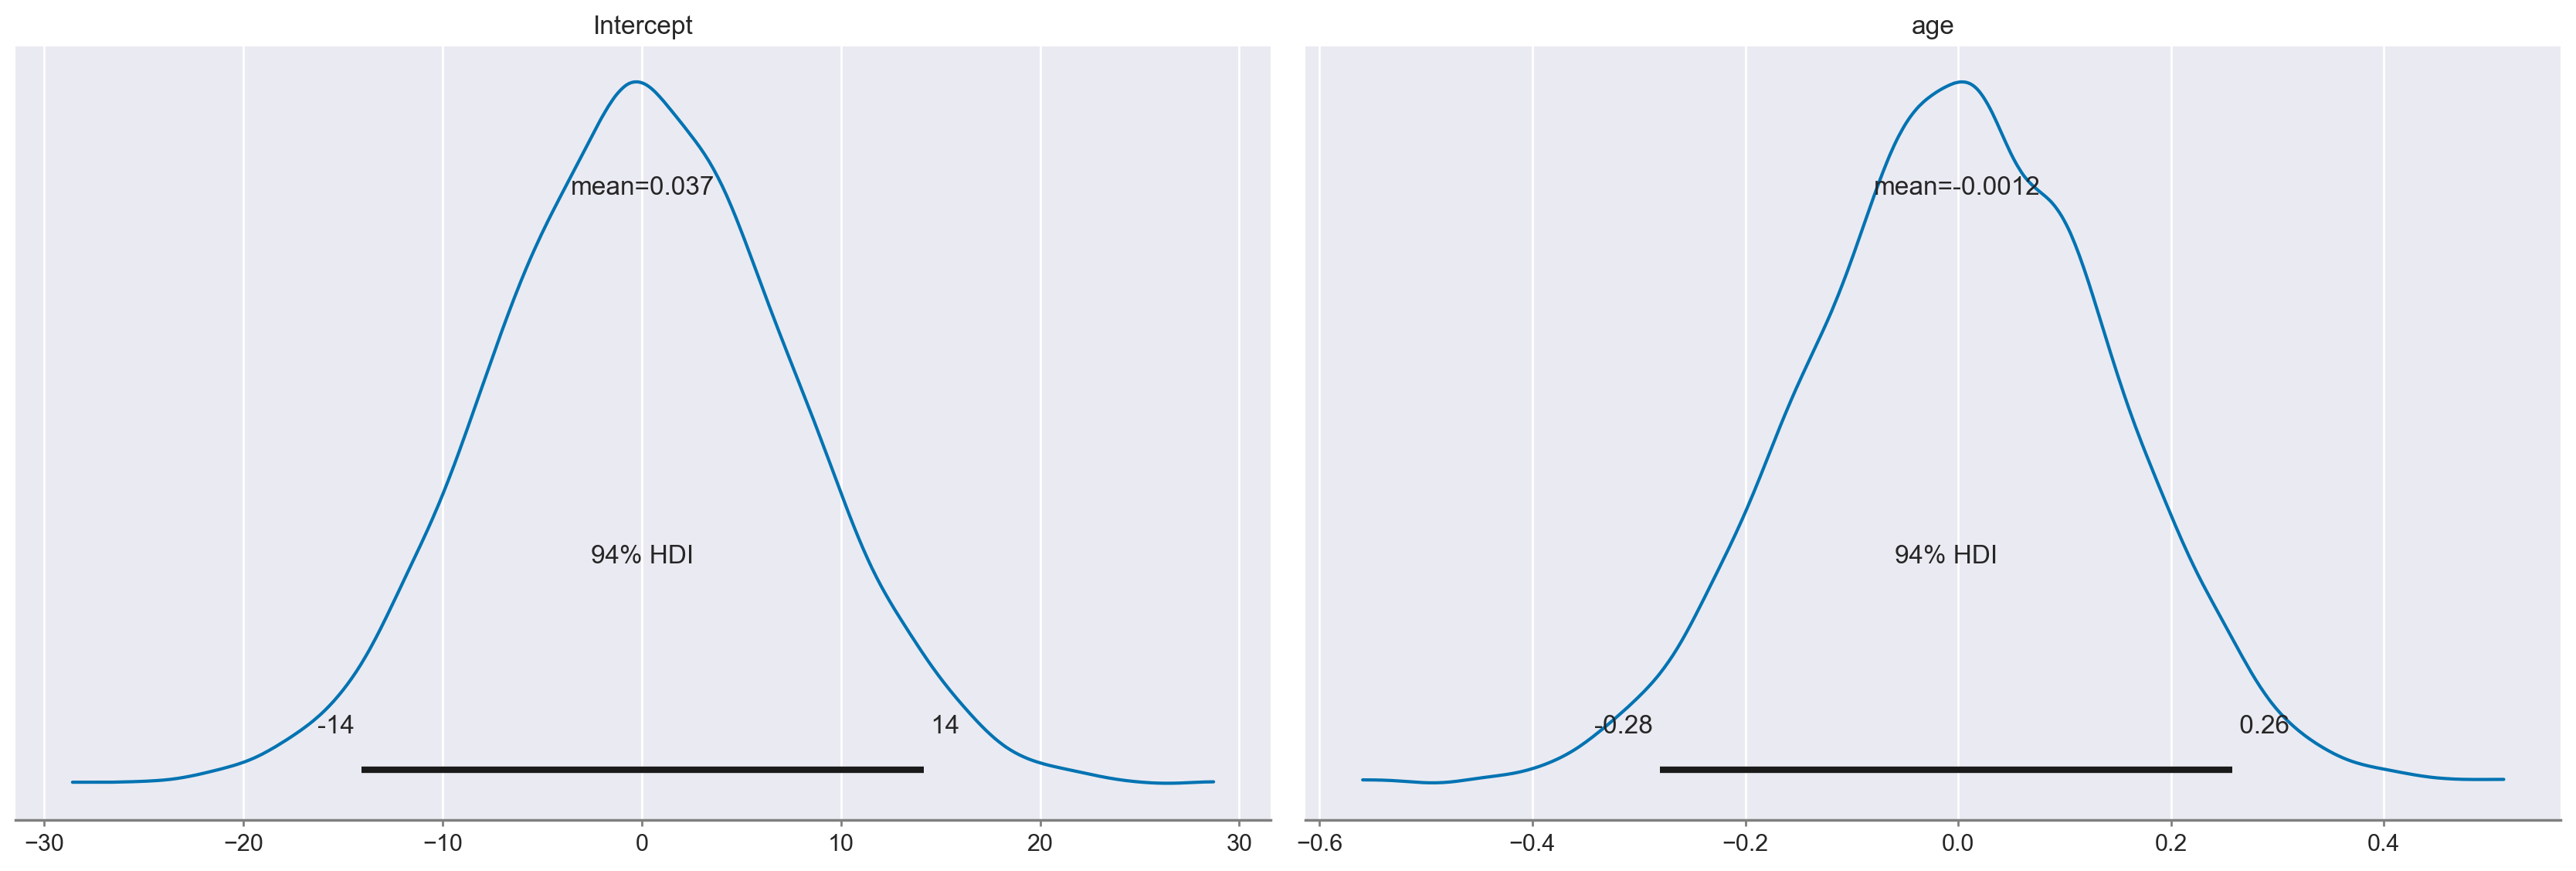

In [12]:
clinton_model.plot_priors()

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>]],
      dtype=object)

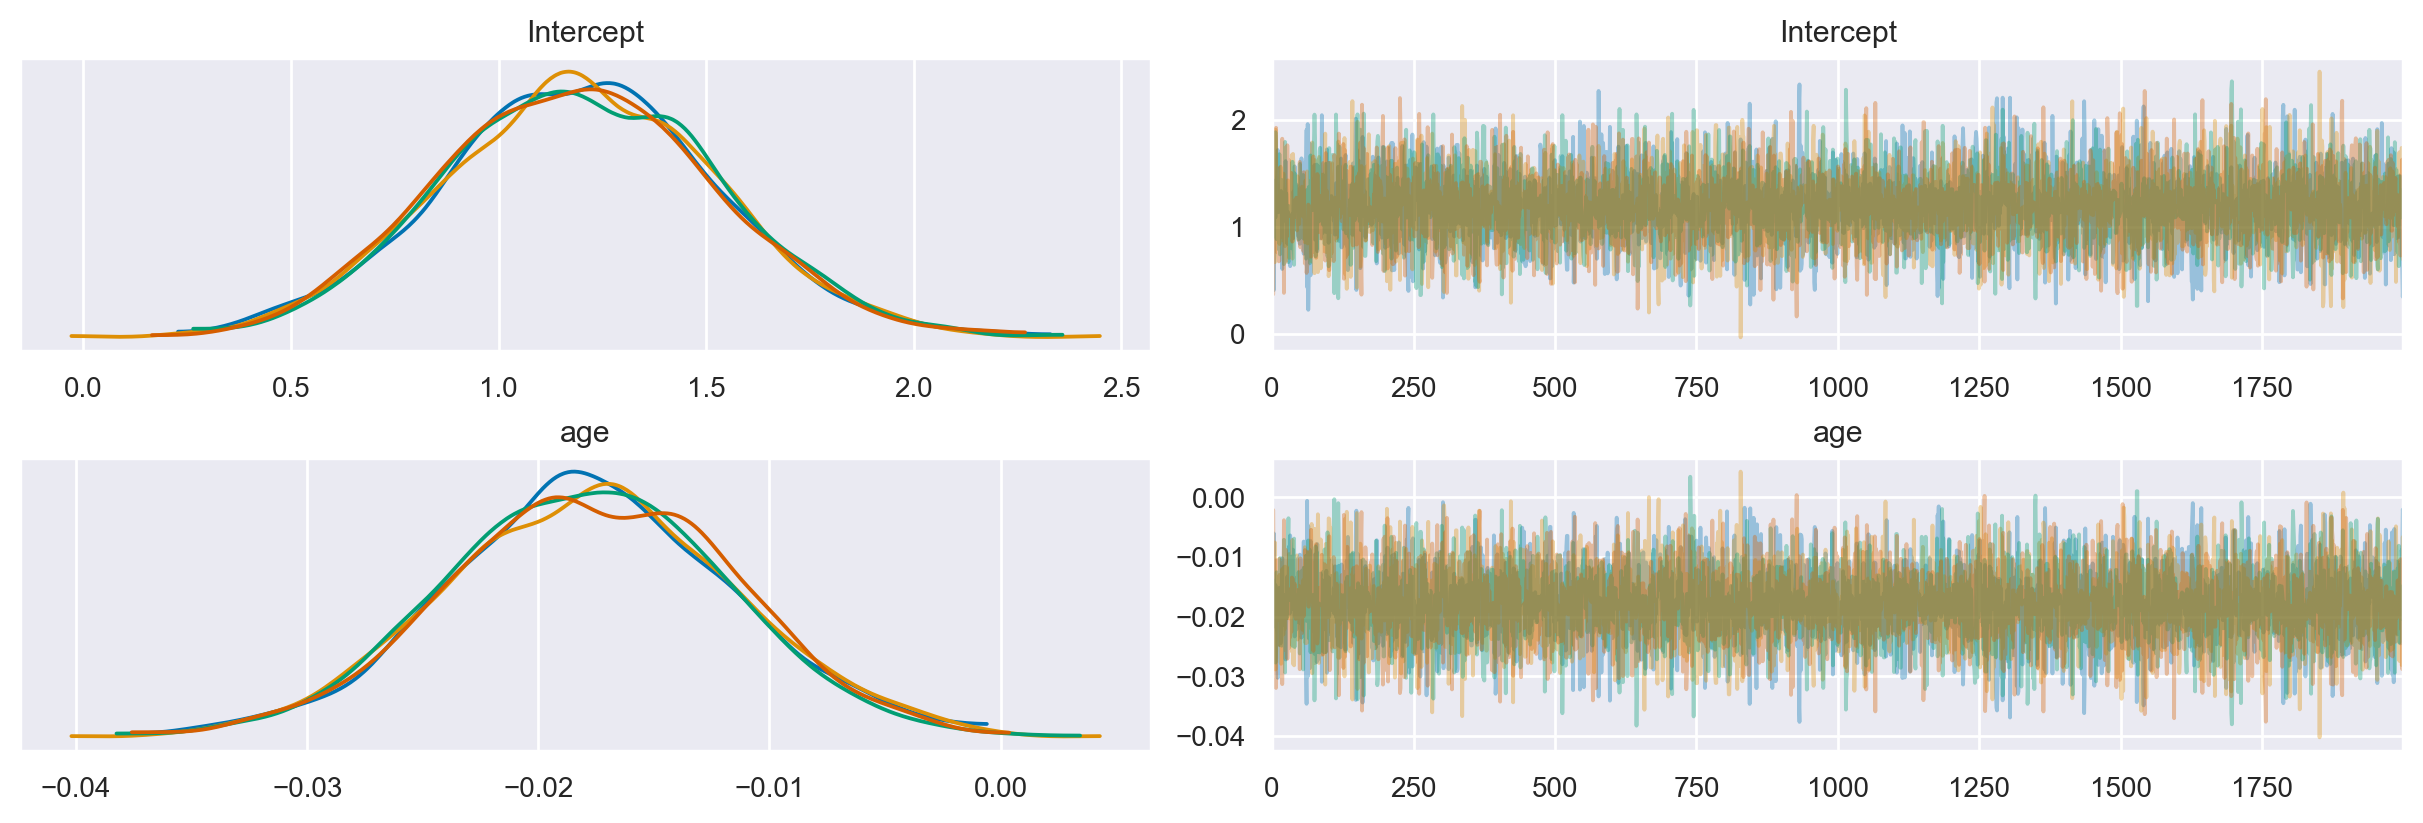

In [13]:
az.plot_trace(clinton_fitted, compact=False)

In [14]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.195,0.330,0.591,1.828,0.004,0.003,8034.0,5956.0,1.0
age,-0.018,0.006,-0.029,-0.006,0.000,0.000,8090.0,5906.0,1.0


In [36]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [37]:
clinton_model.predict(clinton_fitted, data=new_data)

In [44]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

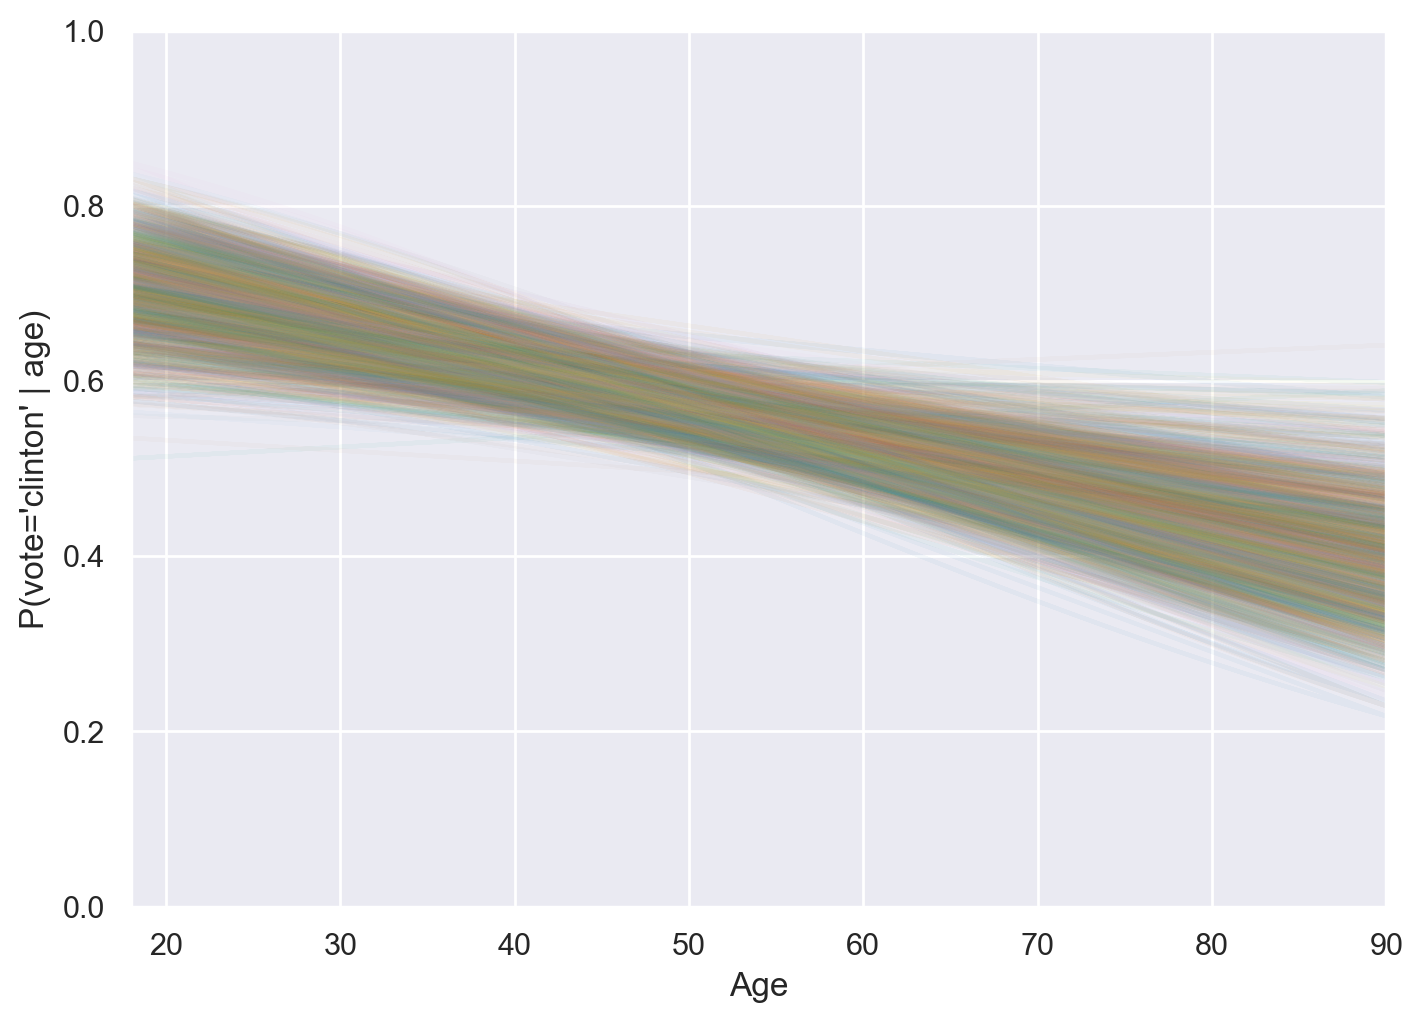

In [47]:
_, ax = plt.subplots(figsize=(7, 5))

ax.plot(new_data.age, vote_posterior, alpha=0.04)

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age")
ax.set_ylim(0, 1)
ax.set_xlim(18, 90);


## Watermark

In [48]:
%watermark -n -u -v -iv -w

Last updated: Wed Aug 02 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.12.0

arviz     : 0.16.0
pandas    : 1.5.3
seaborn   : 0.12.2
numpy     : 1.25.0
bambi     : 0.12.0
matplotlib: 3.7.1

Watermark: 2.4.3

